In [0]:
import pandas as pd
import numpy as np

# load training data
df = pd.read_csv('train_full.csv', usecols=['canSteering', 'canSpeed'])
steer_min = df['canSteering'].min()
steer_max = df['canSteering'].max()
speed_min = df['canSpeed'].min()
speed_max = df['canSpeed'].max()

In [0]:
steer_counts, steer_edges = np.histogramdd(df['canSteering'].to_numpy(), bins=100)
speed_counts, speed_edges = np.histogramdd(df['canSpeed'].to_numpy(), bins=30) 
steer_edges = steer_edges[0]
speed_edges = speed_edges[0]

In [0]:
# load submission files
num_rows = 279863
ensemble_submission = {
    'canSteering': [], 
    'canSpeed': []
}

# ensemble angle
steer_submission_filenames = ['submission Version 21 - Epoch 0.csv',
                              'submission Version 20 - Epoch 0.csv',
                              'submission Version 19 - Epoch 0.csv']
num_steer_submissions = len(steer_submission_filenames)
steer_submissions = np.zeros((num_steer_submissions, num_rows))
submission_steer_counts = np.zeros((num_steer_submissions, num_rows))
for i in range(num_steer_submissions):
    df_submission = pd.read_csv(steer_submission_filenames[i], usecols=['canSteering'])
    assert len(df_submission)== num_rows
    values = df_submission.to_numpy().squeeze()
    steer_submissions[i] = values
    values = np.clip(values, steer_min + 1e-10, steer_max - 1e-10)
    indices = np.zeros(values.shape)
    indices = np.digitize(values, steer_edges) - 1
    indices = indices.astype(int)
    for j in range(num_rows):
        submission_steer_counts[i, j] = steer_counts[indices[j]]

# ensemble speed
speed_submission_filenames = ['submission Version 21 - Epoch 0.csv',
                              'submission Version 20 - Epoch 0.csv',
                              'submission Version 19 - Epoch 0.csv',
                              'submission Version 18 - Epoch 0.csv',
                              'submission Version 17 - Epoch 1.csv']
num_speed_submissions = len(speed_submission_filenames)
speed_submissions = np.zeros((num_speed_submissions, num_rows))
submission_speed_counts = np.zeros((num_speed_submissions, num_rows))
for i in range(num_speed_submissions):
    df_submission = pd.read_csv(speed_submission_filenames[i], usecols=['canSpeed'])
    assert len(df_submission)== num_rows
    values = df_submission.to_numpy().squeeze()
    speed_submissions[i] = values
    values = np.clip(values, speed_min + 1e-10, speed_max - 1e-10)
    indices = np.zeros(values.shape)
    indices = np.digitize(values, speed_edges) - 1
    indices = indices.astype(int)
    for j in range(num_rows):
        submission_speed_counts[i, j] = speed_counts[indices[j]]

# select the most likely submission for each row
for j in range(num_rows):
    steer_counts_j = submission_steer_counts[:, j]
    steer_j = steer_submissions[:, j]
    canSteering = np.dot(steer_counts_j, steer_j) / steer_counts_j.sum()
    speed_counts_j = submission_speed_counts[:, j]
    speed_j = speed_submissions[:, j]
    canSpeed = np.dot(speed_counts_j, speed_j) / speed_counts_j.sum()
    ensemble_submission['canSteering'].append(canSteering)
    ensemble_submission['canSpeed'].append(canSpeed)


In [0]:
from scipy.signal import savgol_filter

# Window should be the max odd number <= num_data_points and cannot exceed max_window
def get_window(num_data_points, max_window):
    assert max_window % 2 == 1
    return min(max_window, (num_data_points - 1) // 2 * 2 + 1)

def knn_online_smooth(speed):
    smoothed = np.zeros(len(speed))
    for i in range(len(smoothed)):
        num_data_points = i + 1
        max_window = 5
        window = get_window(num_data_points, max_window)
        future_window = window // 2
        past_window = window - future_window
        start = max(0, num_data_points - past_window)
        smoothed[i] = speed[i]
        history = speed[start:num_data_points]
        for _ in range(future_window):
            history.append(history[-1])
        smoothed[i] = np.mean(history)
    return smoothed


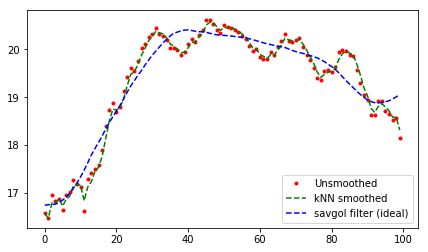

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(ensemble_submission['canSpeed'][700:800], 'r.', label= 'Unsmoothed')
ax.plot(knn_online_smooth(ensemble_submission['canSpeed'])[700:800], 'g--', label="kNN smoothed")
ax.plot(savgol_filter(ensemble_submission['canSpeed'], 51, 2)[700:800], 'b--', label="savgol filter (ideal)")
plt.legend(loc='best')

In [0]:
ensemble_submission['canSpeed'] = list(knn_online_smooth(ensemble_submission['canSpeed']))

In [0]:
df_full_submission = pd.DataFrame.from_dict(ensemble_submission)
df_full_submission.to_csv('ensemble_submission.csv', index=False)